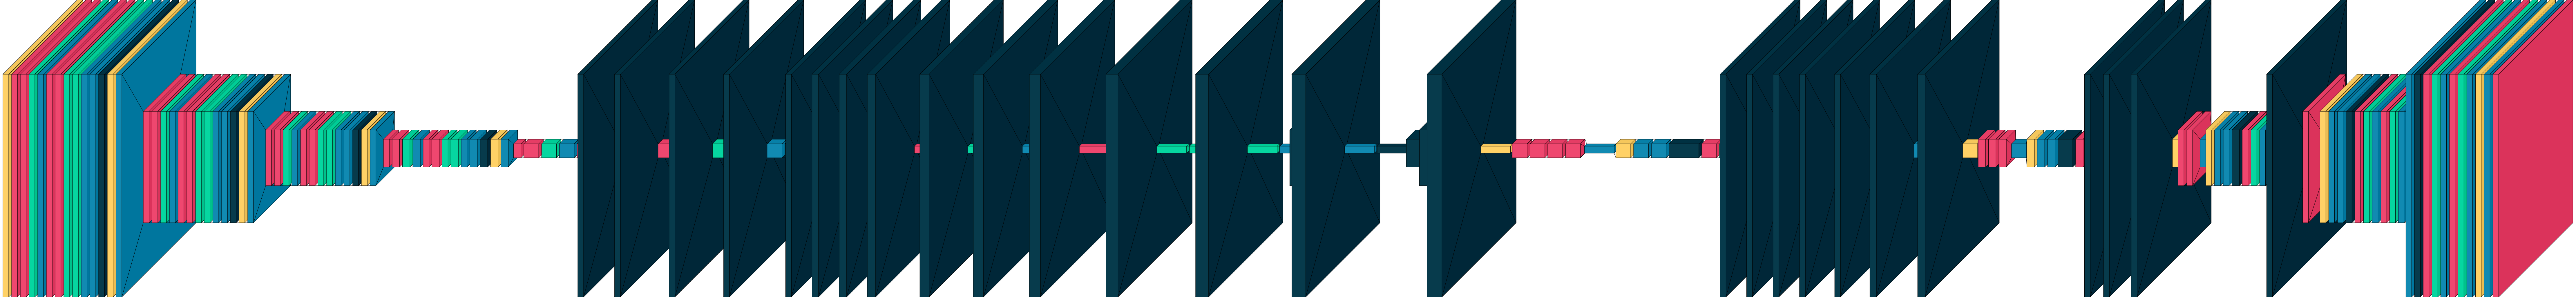

In [11]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization,\
    Activation, Dropout
import keras
import visualkeras

"""
Some parts borrowed from https://www.kaggle.com/cjansen/u-net-in-keras
"""


def bn_relu(input_tensor):
    """It adds a Batch_normalization layer before a Relu
    """
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def contr_arm(input_tensor, filters, kernel_size):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
       TO DO: remove keras.layers.add and replace it with add only
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def imprv_contr_arm(input_tensor, filters, kernel_size ):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = Conv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = Conv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = Conv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    """It is exactly like the identity_block plus a dropout layer. This block only uses in the valley of the UNet
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def conv_block_exp_path3(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    """It is for adding two feed forwards to the output of the two following conv layers in expanding path
    """

    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x


def improve_ff_block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):
    """It improves the skip connection by using previous layers feature maps
       TO DO: shrink all of ff blocks in one function/class
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """
    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)
    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x
def improve_ff_block2(input_tensor1, input_tensor2, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """
    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)
    x = keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x
def improve_ff_block1(input_tensor1, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """
    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x
def model_arch(input_rows=192, input_cols=192, num_of_channels=4, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = imprv_contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = bridge(pool5, 1024, (3, 3))
    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)
    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)
    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)
    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block1(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)
    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)
    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)
    return Model(inputs=[inputs], outputs=[conv12])

model_arch = model_arch()
visualkeras.layered_view(model_arch)


